In [609]:
import pandas as pd
import numpy as np
from datetime import datetime

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve, auc
from sklearn.metrics import precision_recall_curve, f1_score, precision_score, recall_score

from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif, RFE
from sklearn.feature_selection import SelectFromModel

from imblearn.over_sampling import SMOTE, ADASYN
from collections import Counter

import joblib
import json

# Warnings
import warnings
warnings.filterwarnings('ignore')

# Display settings
pd.set_option('display.max_columns', None)

pd.set_option('display.width', None)
print("✓ Libraries imported successfully")

plt.style.use('seaborn-v0_8-darkgrid')

✓ Libraries imported successfully


## 2. Load Data

In [610]:
# Load data
df_raw = pd.read_excel('NPL Prep.xlsx')

print(f"Dataset shape: {df_raw.shape}")
print(f"\nColumns: {df_raw.columns.tolist()}")
print(f"\nFirst 3 rows:")
df_raw.head(3)

Dataset shape: (1500, 15)

Columns: ['Pekerjaan', 'tanggal_lahir', 'Status', 'produk', 'sub_produk', 'tanggal_input', 'plafond', 'jk_waktubulan', 'Hasil Prescreening SLIK', 'Hasil Prescreening SIKPKUR', 'Hasil Prescreening Dukcapil', 'Hasil Prescreening DHNBI', 'Hasil Prescreening', 'Status.1', 'Kolektabilitas']

First 3 rows:


,Pekerjaan,tanggal_lahir,Status,produk,sub_produk,tanggal_input,plafond,jk_waktubulan,Hasil Prescreening SLIK,Hasil Prescreening SIKPKUR,Hasil Prescreening Dukcapil,Hasil Prescreening DHNBI,Hasil Prescreening,Status.1,Kolektabilitas
0,Pegawai pemerintahan/lembaga negara,1978-06-06,Kawin,Konsumer,Kredit Multi Guna,2022-10-03,141200000.0,60,Low,TIDAK DILAKUKAN,Sesuai,Tidak,Lolos,Accept,Lancar
1,"Pengajar (Guru,Dosen)",1975-04-30,Belum Kawin,Konsumer,Kredit Multi Guna,2024-09-27,418000000.0,126,High,TIDAK DILAKUKAN,Sesuai,Tidak,Lolos,Waiting Approval,Tidak Lancar
2,"Pengajar (Guru,Dosen)",1986-03-15,Kawin,Konsumer,Kredit Multi Guna,2024-06-03,265500000.0,192,Low,TIDAK DILAKUKAN,Sesuai,Tidak,Lolos,Accept,Lancar


## 3. Data Understanding

In [611]:
print("DATASET OVERVIEW")
print("="*80)
print(f"Shape: {df_raw.shape}")
print(f"\nData Types:")
print(df_raw.dtypes)
print(f"\nMissing Values:")
print(df_raw.isnull().sum())
print(f"\nDuplicates: {df_raw.duplicated().sum()}")

DATASET OVERVIEW
Shape: (1500, 15)

Data Types:
Pekerjaan                       object
tanggal_lahir                   object
Status                          object
produk                          object
sub_produk                      object
tanggal_input                   object
plafond                        float64
jk_waktubulan                    int64
Hasil Prescreening SLIK         object
Hasil Prescreening SIKPKUR      object
Hasil Prescreening Dukcapil     object
Hasil Prescreening DHNBI        object
Hasil Prescreening              object
Status.1                        object
Kolektabilitas                  object
dtype: object

Missing Values:
Pekerjaan                      0
tanggal_lahir                  0
Status                         0
produk                         0
sub_produk                     0
tanggal_input                  0
plafond                        0
jk_waktubulan                  0
Hasil Prescreening SLIK        0
Hasil Prescreening SIKPKUR     0
Hasil 

In [612]:
# Check unique values for each column
print("UNIQUE VALUES PER COLUMN")
print("="*80)
for col in df_raw.columns:
    n_unique = df_raw[col].nunique()
    print(f"\n{col}: {n_unique} unique values")
    if n_unique <= 10:
        print(f"  Values: {df_raw[col].unique()}")
        print(f"  Distribution:\n{df_raw[col].value_counts()}")

UNIQUE VALUES PER COLUMN

Pekerjaan: 26 unique values

tanggal_lahir: 1419 unique values

Status: 3 unique values
  Values: ['Kawin' 'Belum Kawin' 'Cerai']
  Distribution:
Status
Kawin          1215
Belum Kawin     193
Cerai            92
Name: count, dtype: int64

produk: 2 unique values
  Values: ['Konsumer' 'Mikro']
  Distribution:
produk
Konsumer    1357
Mikro        143
Name: count, dtype: int64

sub_produk: 4 unique values
  Values: ['Kredit Multi Guna' 'Kredit Pemilikan Rumah' 'Mikro Kredit Usaha Rakyat'
 'Mikro Non - Kredit Usaha Rakyat']
  Distribution:
sub_produk
Kredit Multi Guna                  1247
Mikro Kredit Usaha Rakyat           121
Kredit Pemilikan Rumah              110
Mikro Non - Kredit Usaha Rakyat      22
Name: count, dtype: int64

tanggal_input: 887 unique values

plafond: 685 unique values

jk_waktubulan: 169 unique values

Hasil Prescreening SLIK: 3 unique values
  Values: ['Low' 'High' 'Medium']
  Distribution:
Hasil Prescreening SLIK
Low       700
High    

## 4. Feature Engineering: Create USIA

In [613]:
# Copy dataframe
df = df_raw.copy()

# Convert date columns
df['tanggal_lahir'] = pd.to_datetime(df['tanggal_lahir'])
df['tanggal_input'] = pd.to_datetime(df['tanggal_input'])

# Calculate USIA (age in years)
df['Usia'] = ((df['tanggal_input'] - df['tanggal_lahir']).dt.days / 365.25).round(0).astype(int)

print("✓ USIA created")
print(f"\nUSIA Statistics:")
print(df['Usia'].describe())
print(f"\nSample:")
print(df[['tanggal_lahir', 'tanggal_input', 'Usia']].head(10))

✓ USIA created

USIA Statistics:
count    1500.000000
mean       41.837333
std         9.953337
min        19.000000
25%        34.000000
50%        42.000000
75%        49.000000
max        70.000000
Name: Usia, dtype: float64

Sample:
  tanggal_lahir tanggal_input  Usia
0    1978-06-06    2022-10-03    44
1    1975-04-30    2024-09-27    49
2    1986-03-15    2024-06-03    38
3    1971-09-12    2020-07-07    49
4    1976-09-23    2024-04-24    48
5    1981-08-15    2015-02-24    34
6    1989-06-28    2023-09-29    34
7    1989-01-14    2025-03-10    36
8    1979-08-08    2024-01-23    44
9    1960-05-15    2023-09-14    63


## 5. Drop Unnecessary Columns

In [614]:
# Drop date columns (already used to create Usia)
df = df.drop(['tanggal_lahir', 'tanggal_input'], axis=1)

print("✓ Date columns removed")
print(f"\nRemaining columns: {df.columns.tolist()}")

✓ Date columns removed

Remaining columns: ['Pekerjaan', 'Status', 'produk', 'sub_produk', 'plafond', 'jk_waktubulan', 'Hasil Prescreening SLIK', 'Hasil Prescreening SIKPKUR', 'Hasil Prescreening Dukcapil', 'Hasil Prescreening DHNBI', 'Hasil Prescreening', 'Status.1', 'Kolektabilitas', 'Usia']


## 6. Rename Columns

In [615]:
df = df.rename(columns={
    'Status': 'Status Pernikahan',        # Status pernikahan
    'produk': 'Produk',
    'sub_produk': 'Sub Produk',
    'plafond': 'Plafond',
    'jk_waktubulan': 'Jangka Waktu',
    'Hasil Prescreening SIKPKUR': 'Hasil Prescreening SIPKUR',
    'Hasil Prescreening DHNBI': 'Hasil Prescreening DHNBI',
    'Status.1': 'Status Aplikasi'       
})

print("✓ Columns renamed")
print(f"\nFinal columns:")
for i, col in enumerate(df.columns, 1):
    print(f"{i:2d}. {col}")

✓ Columns renamed

Final columns:
 1. Pekerjaan
 2. Status Pernikahan
 3. Produk
 4. Sub Produk
 5. Plafond
 6. Jangka Waktu
 7. Hasil Prescreening SLIK
 8. Hasil Prescreening SIPKUR
 9. Hasil Prescreening Dukcapil
10. Hasil Prescreening DHNBI
11. Hasil Prescreening
12. Status Aplikasi
13. Kolektabilitas
14. Usia


## 7. Target Variable Analysis

TARGET VARIABLE: Kolektabilitas

Distribution:
Kolektabilitas
Lancar          1100
Tidak Lancar     400
Name: count, dtype: int64

Percentage:
Kolektabilitas
Lancar          73.333333
Tidak Lancar    26.666667
Name: proportion, dtype: float64


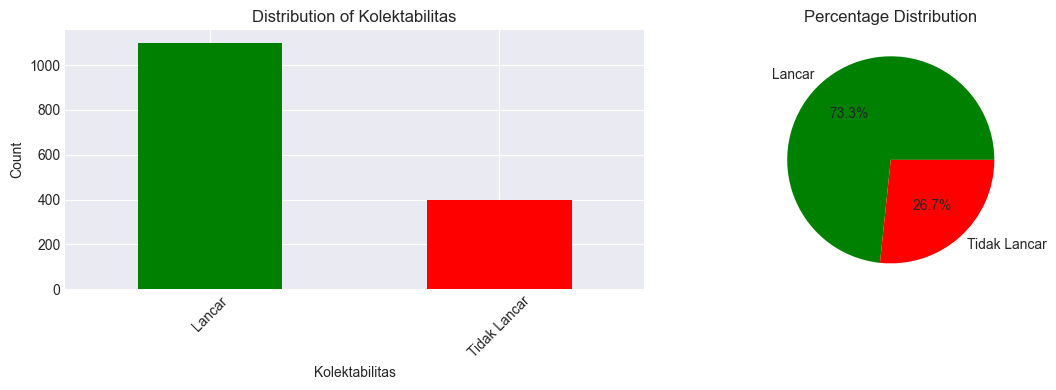

In [616]:
print("TARGET VARIABLE: Kolektabilitas")
print("="*80)
print(f"\nDistribution:")
print(df['Kolektabilitas'].value_counts())
print(f"\nPercentage:")
print(df['Kolektabilitas'].value_counts(normalize=True) * 100)

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

df['Kolektabilitas'].value_counts().plot(kind='bar', ax=axes[0], color=['green', 'red'])
axes[0].set_title('Distribution of Kolektabilitas')
axes[0].set_xlabel('Kolektabilitas')
axes[0].set_ylabel('Count')
axes[0].tick_params(axis='x', rotation=45)

df['Kolektabilitas'].value_counts().plot(kind='pie', ax=axes[1], autopct='%1.1f%%', colors=['green', 'red'])
axes[1].set_title('Percentage Distribution')
axes[1].set_ylabel('')

plt.tight_layout()
plt.show()

## 8. Exploratory Data Analysis - Numerical Features

In [617]:
# Numerical features
num_features = ['Usia', 'Plafond', 'Jangka Waktu']

print("NUMERICAL FEATURES STATISTICS")
print("="*80)
print(df[num_features].describe())

NUMERICAL FEATURES STATISTICS
              Usia       Plafond  Jangka Waktu
count  1500.000000  1.500000e+03   1500.000000
mean     41.837333  2.196511e+08     92.095333
std       9.953337  2.225929e+08     58.359285
min      19.000000  1.914000e+06      5.000000
25%      34.000000  7.500000e+07     48.750000
50%      42.000000  1.655000e+08     67.000000
75%      49.000000  2.828000e+08    121.000000
max      70.000000  3.000000e+09    240.000000


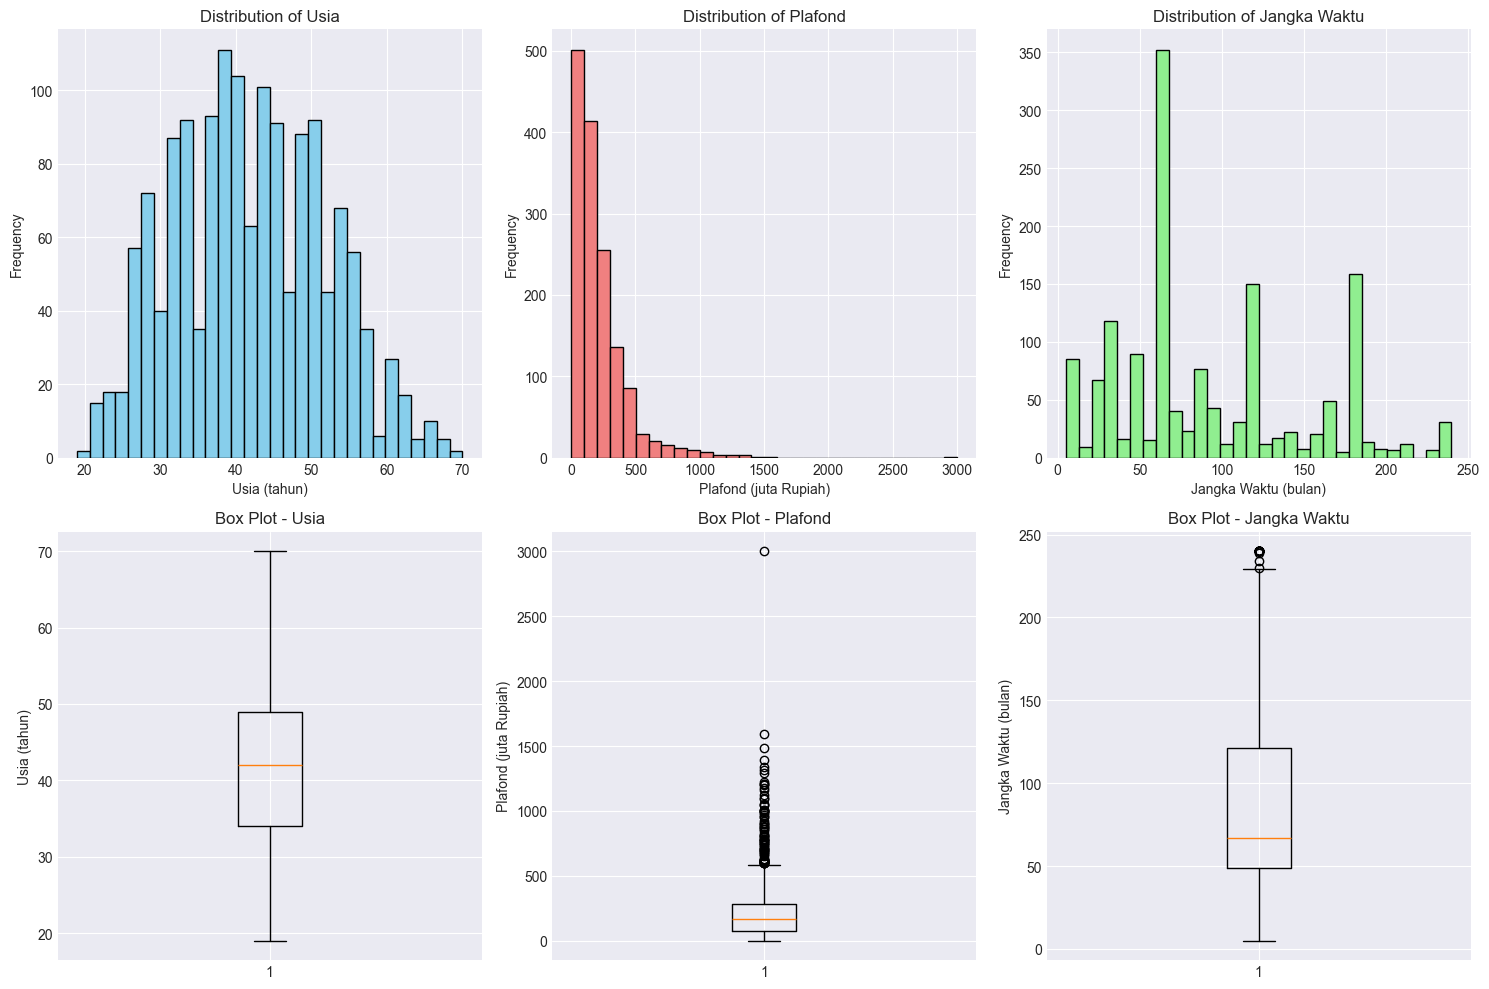

In [618]:
# Visualize numerical features
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Histograms
axes[0, 0].hist(df['Usia'], bins=30, color='skyblue', edgecolor='black')
axes[0, 0].set_title('Distribution of Usia')
axes[0, 0].set_xlabel('Usia (tahun)')
axes[0, 0].set_ylabel('Frequency')

axes[0, 1].hist(df['Plafond']/1e6, bins=30, color='lightcoral', edgecolor='black')
axes[0, 1].set_title('Distribution of Plafond')
axes[0, 1].set_xlabel('Plafond (juta Rupiah)')
axes[0, 1].set_ylabel('Frequency')

axes[0, 2].hist(df['Jangka Waktu'], bins=30, color='lightgreen', edgecolor='black')
axes[0, 2].set_title('Distribution of Jangka Waktu')
axes[0, 2].set_xlabel('Jangka Waktu (bulan)')
axes[0, 2].set_ylabel('Frequency')

# Box plots
axes[1, 0].boxplot(df['Usia'])
axes[1, 0].set_title('Box Plot - Usia')
axes[1, 0].set_ylabel('Usia (tahun)')

axes[1, 1].boxplot(df['Plafond']/1e6)
axes[1, 1].set_title('Box Plot - Plafond')
axes[1, 1].set_ylabel('Plafond (juta Rupiah)')

axes[1, 2].boxplot(df['Jangka Waktu'])
axes[1, 2].set_title('Box Plot - Jangka Waktu')
axes[1, 2].set_ylabel('Jangka Waktu (bulan)')

plt.tight_layout()
plt.show()

## 9. Exploratory Data Analysis - Categorical Features

In [619]:
# Categorical features
cat_features = ['Pekerjaan', 'Status Pernikahan', 'Produk', 'Sub Produk', 
                'Hasil Prescreening SLIK', 'Hasil Prescreening SIPKUR', 
                'Hasil Prescreening Dukcapil', 'Hasil Prescreening DHNBI',
                'Hasil Prescreening', 'Status Aplikasi']

print("CATEGORICAL FEATURES SUMMARY")
print("="*80)
for feature in cat_features:
    print(f"\n{feature}:")
    print(df[feature].value_counts())
    print("-"*80)

CATEGORICAL FEATURES SUMMARY

Pekerjaan:
Pekerjaan
Pegawai pemerintahan/lembaga negara              433
Pengajar (Guru,Dosen)                            297
Lain-Lain                                        213
Wiraswasta                                       116
Administrasi umum                                107
Tenaga Medis (Perawat, Bidan, dan sebagainya)     67
Pensiunan                                         48
Eksekutif                                         45
Transportasi darat (masinis, sopir,kondektur)     41
Pengamanan                                        32
Pelajar/Mahasiswa                                 24
Marketing                                         14
Ibu rumah tangga                                   9
Pejabat negara/penyelenggara negara                7
Konsultan/Analis                                   7
Teknologi informasi                                7
Accounting/Finance Officer                         7
Dokter                                          

## 10. Analyze Relationship with Target Variable

In [620]:
# Analyze each categorical feature vs Kolektabilitas
print("RELATIONSHIP: CATEGORICAL FEATURES vs KOLEKTABILITAS")
print("="*80)

for feature in cat_features:
    print(f"\n{feature} vs Kolektabilitas:")
    print("-"*80)
    ct = pd.crosstab(df[feature], df['Kolektabilitas'], margins=True, normalize='index')
    print(ct)
    print()

RELATIONSHIP: CATEGORICAL FEATURES vs KOLEKTABILITAS

Pekerjaan vs Kolektabilitas:
--------------------------------------------------------------------------------
Kolektabilitas                                   Lancar  Tidak Lancar
Pekerjaan                                                            
Accounting/Finance Officer                     0.857143      0.142857
Administrasi umum                              0.757009      0.242991
Buruh (buruh pabrik,buruh bangunan,buruhtani)  1.000000      0.000000
Dokter                                         1.000000      0.000000
Eksekutif                                      0.844444      0.155556
Engineering                                    0.750000      0.250000
Hukum (Pengacara, Notaris)                     0.500000      0.500000
Ibu rumah tangga                               0.777778      0.222222
Konsultan/Analis                               0.285714      0.714286
Lain-Lain                                      0.760563      0.239

## 11. Remove Data Leakage & Prepare Features

⚠️ **DATA LEAKAGE DETECTED!**

Analisis menunjukkan 1 kolom mengandung informasi yang bocorkan target:
1. **Hasil Prescreening SLIK** - High=100% Tidak Lancar, Low/Medium=100% Lancar

Kolom ini akan **DIHAPUS** untuk mencegah overfitting.

In [621]:
# Remove features with data leakage
print("REMOVING FEATURES WITH DATA LEAKAGE & PROBLEMATIC FEATURES")
print("="*80)

leakage_features = [
    
]

print(f"\nRemoving {len(leakage_features)} features:")
for i, feature in enumerate(leakage_features, 1):
    print(f"  {i}. {feature}")

available_features = [
    "Hasil Prescreening SLIK",  
    "Hasil Prescreening",
    "Pekerjaan", 
    "Usia",
    "Status Pernikahan",
    "Produk",
    "Sub Produk",
    "Plafond",
    "Jangka Waktu",
    "Hasil Prescreening SIPKUR",
    "Hasil Prescreening Dukcapil",
    "Hasil Prescreening DHNBI",
    "Status Aplikasi",
]

# Prepare X and y
X = df[available_features].copy()
y = df['Kolektabilitas'].copy()

print(f"\nAvailable features: {len(available_features)}")
print(f"\nFeature list:")
for i, col in enumerate(available_features, 1):
    print(f"{i:2d}. {col}")
print(f"\nX shape: {X.shape}")
print(f"y shape: {y.shape}")

REMOVING FEATURES WITH DATA LEAKAGE & PROBLEMATIC FEATURES

Removing 0 features:

Available features: 13

Feature list:
 1. Hasil Prescreening SLIK
 2. Hasil Prescreening
 3. Pekerjaan
 4. Usia
 5. Status Pernikahan
 6. Produk
 7. Sub Produk
 8. Plafond
 9. Jangka Waktu
10. Hasil Prescreening SIPKUR
11. Hasil Prescreening Dukcapil
12. Hasil Prescreening DHNBI
13. Status Aplikasi

X shape: (1500, 13)
y shape: (1500,)


## 12. Encode Categorical Features

In [622]:
# Encode categorical features
label_encoders = {}
X_encoded = X.copy()

categorical_columns = X_encoded.select_dtypes(include=['object']).columns

print("ENCODING CATEGORICAL FEATURES")
print("="*80)
for col in categorical_columns:
    le = LabelEncoder()
    X_encoded[col] = le.fit_transform(X_encoded[col].astype(str))
    label_encoders[col] = le
    print(f"✓ {col}: {len(le.classes_)} categories")

# Encode target
target_encoder = LabelEncoder()
y_encoded = target_encoder.fit_transform(y)

print(f"\n✓ Target encoded: {dict(zip(target_encoder.classes_, target_encoder.transform(target_encoder.classes_)))}")
print(f"\nX_encoded shape: {X_encoded.shape}")
print(f"y_encoded shape: {y_encoded.shape}")

ENCODING CATEGORICAL FEATURES
✓ Hasil Prescreening SLIK: 3 categories
✓ Hasil Prescreening: 3 categories
✓ Pekerjaan: 26 categories
✓ Status Pernikahan: 3 categories
✓ Produk: 2 categories
✓ Sub Produk: 4 categories
✓ Hasil Prescreening SIPKUR: 4 categories
✓ Hasil Prescreening Dukcapil: 2 categories
✓ Hasil Prescreening DHNBI: 2 categories
✓ Status Aplikasi: 4 categories

✓ Target encoded: {'Lancar': np.int64(0), 'Tidak Lancar': np.int64(1)}

X_encoded shape: (1500, 13)
y_encoded shape: (1500,)


## 13. Automatic Feature Selection

Menggunakan 3 metode feature selection:
1. **Chi-Square Test** - Untuk categorical features
2. **Mutual Information** - Mengukur dependency antara features dan target
3. **Random Forest Feature Importance** - Tree-based feature importance

AUTOMATIC FEATURE SELECTION

1. CHI-SQUARE TEST
--------------------------------------------------------------------------------
                    Feature  Chi2_Score      P_Value
    Hasil Prescreening SLIK  272.727273 2.887506e-61
            Status Aplikasi  261.356315 8.687099e-59
Hasil Prescreening Dukcapil   58.298701 2.251927e-14
         Hasil Prescreening   47.489875 5.528877e-12
   Hasil Prescreening DHNBI   31.475248 2.019989e-08
                     Produk    2.212969 1.368551e-01
  Hasil Prescreening SIPKUR    1.342741 2.465512e-01
                 Sub Produk    1.253607 2.628647e-01
                  Pekerjaan    0.463563 4.959636e-01
               Jangka Waktu    0.036460 8.485681e-01
                    Plafond    0.005163 9.427208e-01
          Status Pernikahan    0.000288 9.864514e-01
                       Usia    0.000234 9.878059e-01


2. MUTUAL INFORMATION
--------------------------------------------------------------------------------
                    Feat

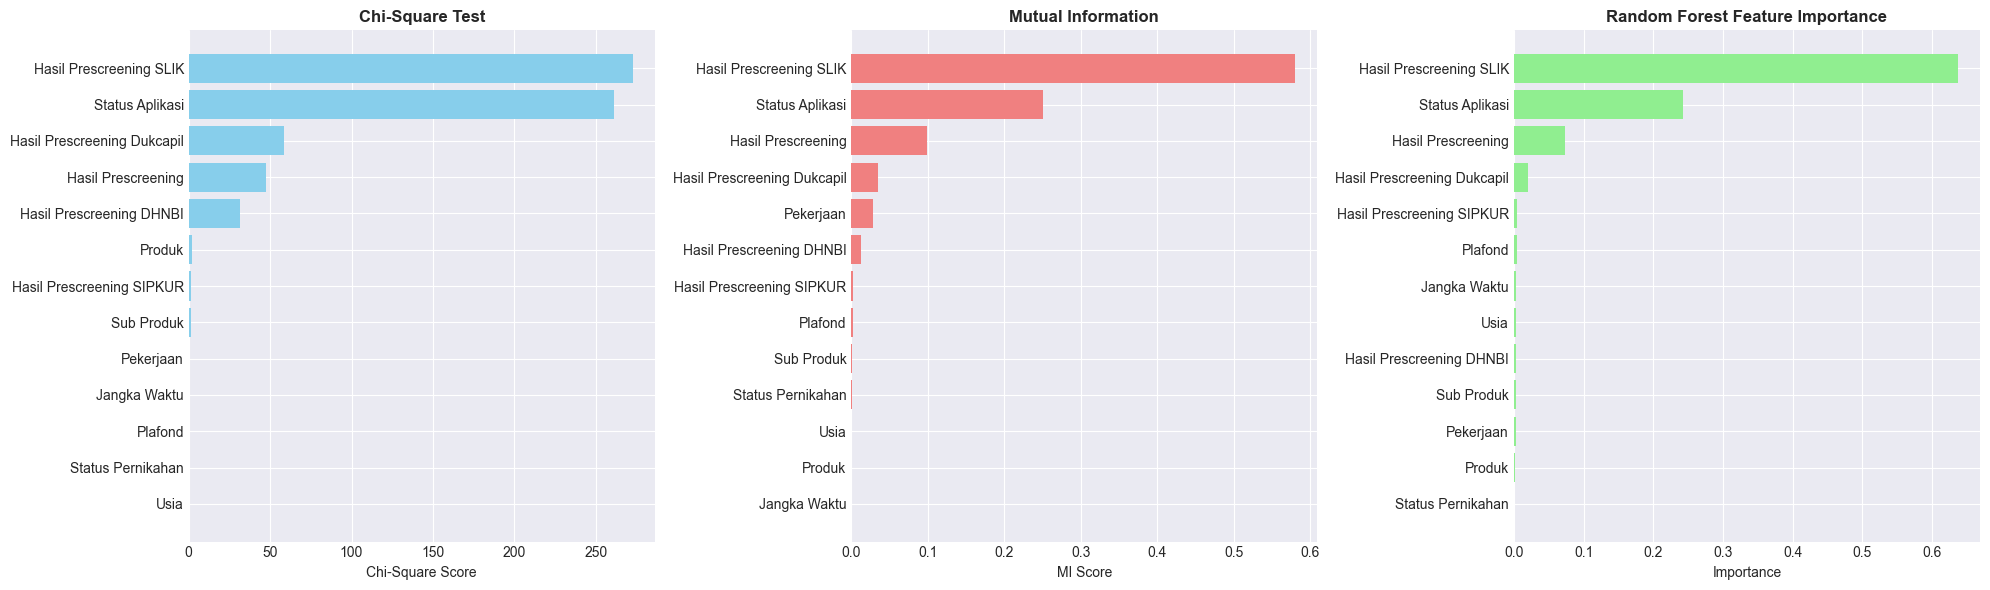


✓ Feature selection analysis complete!


In [623]:
print("AUTOMATIC FEATURE SELECTION")
print("="*80)

# Normalize features untuk feature selection (karena ada skala berbeda)
scaler_fs = MinMaxScaler()
X_normalized = scaler_fs.fit_transform(X_encoded)

# 1. Chi-Square Test
print("\n1. CHI-SQUARE TEST")
print("-"*80)
chi2_selector = SelectKBest(chi2, k='all')
chi2_selector.fit(X_normalized, y_encoded)
chi2_scores = chi2_selector.scores_
chi2_pvalues = chi2_selector.pvalues_

chi2_df = pd.DataFrame({
    'Feature': X_encoded.columns,
    'Chi2_Score': chi2_scores,
    'P_Value': chi2_pvalues
}).sort_values('Chi2_Score', ascending=False)

print(chi2_df.to_string(index=False))

# 2. Mutual Information
print("\n\n2. MUTUAL INFORMATION")
print("-"*80)
mi_scores = mutual_info_classif(X_encoded, y_encoded, random_state=42)
mi_df = pd.DataFrame({
    'Feature': X_encoded.columns,
    'MI_Score': mi_scores
}).sort_values('MI_Score', ascending=False)

print(mi_df.to_string(index=False))

# 3. Random Forest Feature Importance
print("\n\n3. RANDOM FOREST FEATURE IMPORTANCE")
print("-"*80)
rf_selector = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_selector.fit(X_encoded, y_encoded)
rf_importance = rf_selector.feature_importances_

rf_importance_df = pd.DataFrame({
    'Feature': X_encoded.columns,
    'Importance': rf_importance
}).sort_values('Importance', ascending=False)

print(rf_importance_df.to_string(index=False))

# Visualisasi
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# Chi-Square
axes[0].barh(chi2_df['Feature'], chi2_df['Chi2_Score'], color='skyblue')
axes[0].set_xlabel('Chi-Square Score')
axes[0].set_title('Chi-Square Test', fontweight='bold')
axes[0].invert_yaxis()

# Mutual Information
axes[1].barh(mi_df['Feature'], mi_df['MI_Score'], color='lightcoral')
axes[1].set_xlabel('MI Score')
axes[1].set_title('Mutual Information', fontweight='bold')
axes[1].invert_yaxis()

# Random Forest Importance
axes[2].barh(rf_importance_df['Feature'], rf_importance_df['Importance'], color='lightgreen')
axes[2].set_xlabel('Importance')
axes[2].set_title('Random Forest Feature Importance', fontweight='bold')
axes[2].invert_yaxis()

plt.tight_layout()
plt.show()

print("\n✓ Feature selection analysis complete!")

## 14. Select Best Features Based on Voting

SELECTING BEST FEATURES BASED ON VOTING

COMBINED FEATURE SCORES (Voting dari 3 metode):
                    Feature  Chi2_Normalized  MI_Normalized  RF_Normalized  Average_Score
    Hasil Prescreening SLIK     1.000000e+00       1.000000       0.636886       0.878962
         Hasil Prescreening     9.583065e-01       0.431256       0.242827       0.544130
                  Pekerjaan     2.137612e-01       0.169714       0.073401       0.152292
                       Usia     1.741288e-01       0.060430       0.020628       0.085062
          Status Pernikahan     1.154085e-01       0.048638       0.004100       0.056049
                     Produk     8.113370e-03       0.022332       0.004057       0.011501
                 Sub Produk     4.922530e-03       0.004085       0.003725       0.004244
                    Plafond     4.595705e-03       0.003378       0.003537       0.003837
               Jangka Waktu     1.698875e-03       0.002589       0.003391       0.002560
  Hasil Pre

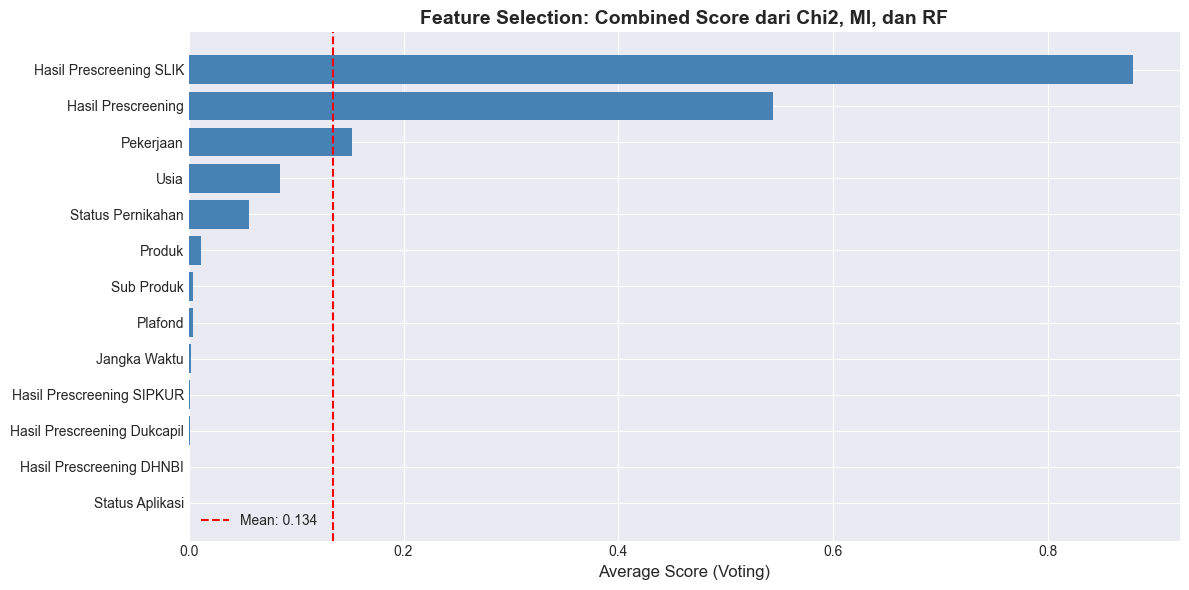



4. RECURSIVE FEATURE ELIMINATION (RFE)
--------------------------------------------------------------------------------
                    Feature  Selected  Ranking
    Hasil Prescreening SLIK      True        1
         Hasil Prescreening      True        1
                    Plafond      True        1
               Jangka Waktu      True        1
  Hasil Prescreening SIPKUR      True        1
Hasil Prescreening Dukcapil      True        1
            Status Aplikasi      True        1
                 Sub Produk     False        2
                       Usia     False        3
   Hasil Prescreening DHNBI     False        4
                  Pekerjaan     False        5
                     Produk     False        6
          Status Pernikahan     False        7


FINAL FEATURE SELECTION

✅ SELECTED FEATURES: 12 dari 13

Features selected by RFE: 7
Features selected by Score: 7
Final union: 12


Final Selected Features (sorted by combined score):
 1. Hasil Prescreening SLIK     

In [624]:
print("SELECTING BEST FEATURES BASED ON VOTING")
print("="*80)

# Normalisasi scores ke range 0-1 untuk setiap metode
from sklearn.preprocessing import MinMaxScaler

# Normalize Chi2 scores
chi2_normalized = MinMaxScaler().fit_transform(chi2_df['Chi2_Score'].values.reshape(-1, 1)).flatten()

# Normalize MI scores  
mi_normalized = MinMaxScaler().fit_transform(mi_df['MI_Score'].values.reshape(-1, 1)).flatten()

# RF importance sudah dalam range 0-1
rf_normalized = rf_importance_df['Importance'].values

# Buat combined dataframe
combined_df = pd.DataFrame({
    'Feature': X_encoded.columns,
    'Chi2_Normalized': chi2_normalized,
    'MI_Normalized': mi_normalized,
    'RF_Normalized': rf_normalized
})

# Hitung average score dari 3 metode (voting)
combined_df['Average_Score'] = combined_df[['Chi2_Normalized', 'MI_Normalized', 'RF_Normalized']].mean(axis=1)
combined_df = combined_df.sort_values('Average_Score', ascending=False)

print("\nCOMBINED FEATURE SCORES (Voting dari 3 metode):")
print(combined_df.to_string(index=False))

# Visualisasi combined scores
plt.figure(figsize=(12, 6))
plt.barh(combined_df['Feature'], combined_df['Average_Score'], color='steelblue')
plt.xlabel('Average Score (Voting)', fontsize=12)
plt.title('Feature Selection: Combined Score dari Chi2, MI, dan RF', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.axvline(x=combined_df['Average_Score'].mean(), color='red', linestyle='--', label=f'Mean: {combined_df["Average_Score"].mean():.3f}')
plt.legend()
plt.tight_layout()
plt.show()

# Strategi: Gunakan RFE untuk memilih top features
print("\n\n4. RECURSIVE FEATURE ELIMINATION (RFE)")
print("-"*80)

# RFE dengan Random Forest
rfe_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
n_features_to_select = max(7, len(X_encoded.columns) // 2)  # Pilih 50% atau minimal 7 features

rfe = RFE(estimator=rfe_model, n_features_to_select=n_features_to_select, step=1)
rfe.fit(X_encoded, y_encoded)

rfe_df = pd.DataFrame({
    'Feature': X_encoded.columns,
    'Selected': rfe.support_,
    'Ranking': rfe.ranking_
}).sort_values('Ranking')

print(rfe_df.to_string(index=False))

# Pilih features berdasarkan RFE dan Combined Score
print("\n\n" + "="*80)
print("FINAL FEATURE SELECTION")
print("="*80)

# Features yang dipilih RFE
rfe_selected = rfe_df[rfe_df['Selected'] == True]['Feature'].tolist()

# Tambahkan features dengan average score tinggi (backup strategy)
top_features_by_score = combined_df.nlargest(n_features_to_select, 'Average_Score')['Feature'].tolist()

# Gabungkan dengan union (ambil yang dipilih salah satu metode)
selected_features = list(set(rfe_selected) | set(top_features_by_score))

print(f"\n✅ SELECTED FEATURES: {len(selected_features)} dari {len(X_encoded.columns)}")
print(f"\nFeatures selected by RFE: {len(rfe_selected)}")
print(f"Features selected by Score: {len(top_features_by_score)}")
print(f"Final union: {len(selected_features)}")

print("\n\nFinal Selected Features (sorted by combined score):")
final_df = combined_df[combined_df['Feature'].isin(selected_features)].sort_values('Average_Score', ascending=False)
for i, row in enumerate(final_df.itertuples(), 1):
    rfe_mark = "✓ RFE" if row.Feature in rfe_selected else ""
    score_mark = "✓ Score" if row.Feature in top_features_by_score else ""
    print(f"{i:2d}. {row.Feature:35s} (Score: {row.Average_Score:.4f}) {rfe_mark} {score_mark}")

# Update X_encoded dengan selected features
X_selected = X_encoded[selected_features].copy()
feature_columns = selected_features

print(f"\n✓ X_selected shape: {X_selected.shape}")
print(f"✓ Features reduced from {len(X_encoded.columns)} to {len(selected_features)}")

## 15. Train-Test Split

In [625]:
# Split data menggunakan selected features
X_train, X_test, y_train, y_test = train_test_split(
    X_selected, y_encoded, 
    test_size=0.2, 
    random_state=42, 
    stratify=y_encoded
)

print("DATA SPLIT")
print("="*80)
print(f"Training set: {len(X_train)} samples ({len(X_train)/len(X_selected)*100:.1f}%)")
print(f"Test set: {len(X_test)} samples ({len(X_test)/len(X_selected)*100:.1f}%)")
print(f"\nTraining set distribution:")
print(pd.Series(y_train).value_counts())
print(f"\nTest set distribution:")
print(pd.Series(y_test).value_counts())

DATA SPLIT
Training set: 1200 samples (80.0%)
Test set: 300 samples (20.0%)

Training set distribution:
0    880
1    320
Name: count, dtype: int64

Test set distribution:
0    220
1     80
Name: count, dtype: int64


## 16. Handle Imbalanced Data

Dataset memiliki **imbalanced class**:
- Lancar: 73.3% (1100 samples)
- Tidak Lancar: 26.7% (400 samples)

Kita akan membuat 3 versi dataset untuk perbandingan:
1. **Original** - tanpa handling imbalanced
2. **SMOTE** - Synthetic Minority Over-sampling Technique
3. **ADASYN** - Adaptive Synthetic Sampling

HANDLING IMBALANCED DATA

1. ORIGINAL DATASET:
   Training set distribution:
     Lancar: 880 (73.33%)
     Tidak Lancar: 320 (26.67%)

2. APPLYING SMOTE...
   After SMOTE:
     Lancar: 880 (50.00%)
     Tidak Lancar: 880 (50.00%)

3. APPLYING ADASYN...
   After ADASYN:
     Lancar: 880 (51.52%)
     Tidak Lancar: 828 (48.48%)

SUMMARY:
  Original    : 1200 samples
  SMOTE       : 1760 samples (+560)
  ADASYN      : 1708 samples (+508)
  Test set    : 300 samples (same for all)


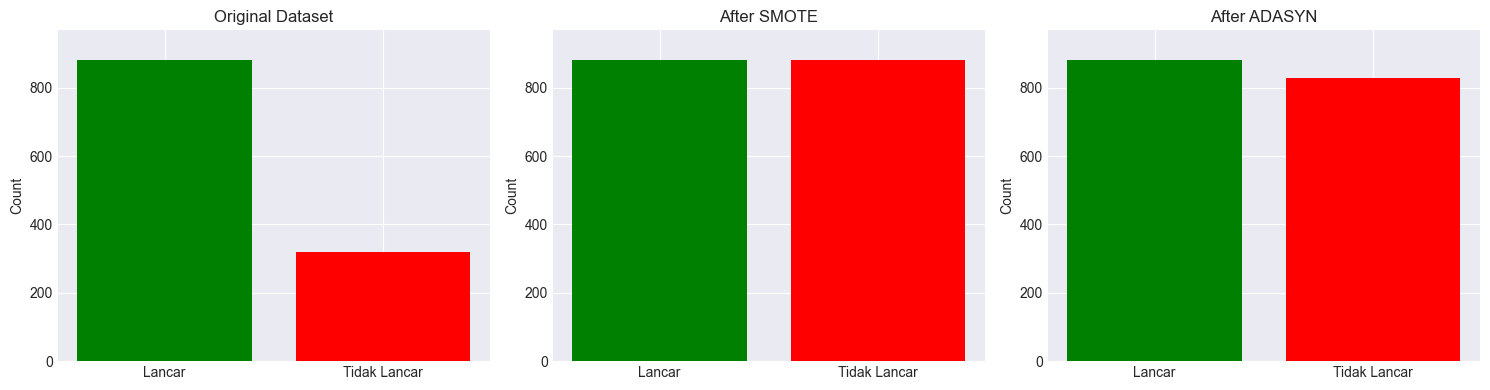

In [626]:
print("HANDLING IMBALANCED DATA")
print("="*80)

# Check original distribution
print(f"\n1. ORIGINAL DATASET:")
print(f"   Training set distribution:")
original_dist = Counter(y_train)
for label, count in original_dist.items():
    label_name = target_encoder.inverse_transform([label])[0]
    pct = count / len(y_train) * 100
    print(f"     {label_name}: {count} ({pct:.2f}%)")

# Apply SMOTE
print(f"\n2. APPLYING SMOTE...")
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

print(f"   After SMOTE:")
smote_dist = Counter(y_train_smote)
for label, count in smote_dist.items():
    label_name = target_encoder.inverse_transform([label])[0]
    pct = count / len(y_train_smote) * 100
    print(f"     {label_name}: {count} ({pct:.2f}%)")

# Apply ADASYN
print(f"\n3. APPLYING ADASYN...")
adasyn = ADASYN(random_state=42)
X_train_adasyn, y_train_adasyn = adasyn.fit_resample(X_train, y_train)

print(f"   After ADASYN:")
adasyn_dist = Counter(y_train_adasyn)
for label, count in adasyn_dist.items():
    label_name = target_encoder.inverse_transform([label])[0]
    pct = count / len(y_train_adasyn) * 100
    print(f"     {label_name}: {count} ({pct:.2f}%)")

print(f"\n{'='*80}")
print("SUMMARY:")
print(f"  Original    : {len(X_train)} samples")
print(f"  SMOTE       : {len(X_train_smote)} samples (+{len(X_train_smote)-len(X_train)})")
print(f"  ADASYN      : {len(X_train_adasyn)} samples (+{len(X_train_adasyn)-len(X_train)})")
print(f"  Test set    : {len(X_test)} samples (same for all)")
print(f"{'='*80}")

# Visualize distribution
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Original
axes[0].bar(['Lancar', 'Tidak Lancar'], 
            [original_dist[0], original_dist[1]], 
            color=['green', 'red'])
axes[0].set_title('Original Dataset')
axes[0].set_ylabel('Count')
axes[0].set_ylim([0, max(smote_dist.values()) * 1.1])

# SMOTE
axes[1].bar(['Lancar', 'Tidak Lancar'], 
            [smote_dist[0], smote_dist[1]], 
            color=['green', 'red'])
axes[1].set_title('After SMOTE')
axes[1].set_ylabel('Count')
axes[1].set_ylim([0, max(smote_dist.values()) * 1.1])

# ADASYN
axes[2].bar(['Lancar', 'Tidak Lancar'], 
            [adasyn_dist[0], adasyn_dist[1]], 
            color=['green', 'red'])
axes[2].set_title('After ADASYN')
axes[2].set_ylabel('Count')
axes[2].set_ylim([0, max(smote_dist.values()) * 1.1])

plt.tight_layout()
plt.show()

## 17. Feature Scaling (for all 3 datasets)

In [627]:
print("FEATURE SCALING")
print("="*80)

# Scale Original dataset
scaler_original = StandardScaler()
X_train_scaled = scaler_original.fit_transform(X_train)
X_test_scaled = scaler_original.transform(X_test)
print("✓ Original dataset scaled")

# Scale SMOTE dataset
scaler_smote = StandardScaler()
X_train_smote_scaled = scaler_smote.fit_transform(X_train_smote)
X_test_smote_scaled = scaler_smote.transform(X_test)
print("✓ SMOTE dataset scaled")

# Scale ADASYN dataset
scaler_adasyn = StandardScaler()
X_train_adasyn_scaled = scaler_adasyn.fit_transform(X_train_adasyn)
X_test_adasyn_scaled = scaler_adasyn.transform(X_test)
print("✓ ADASYN dataset scaled")

print(f"\n{'='*80}")
print("Ready for model training with 3 different datasets!")
print(f"{'='*80}")

FEATURE SCALING
✓ Original dataset scaled
✓ SMOTE dataset scaled
✓ ADASYN dataset scaled

Ready for model training with 3 different datasets!


## 18. Model Training with All 3 Datasets

Melatih **4 model** (Random Forest, XGBoost, LightGBM, Gradient Boosting) dengan **3 dataset** (Original, SMOTE, ADASYN).
Total: **12 kombinasi**

In [628]:
print("TRAINING MODELS WITH 3 DATASETS")
print("="*80)

# Store all results
all_results = []

# Define datasets
datasets = {
    'Original': (X_train_scaled, y_train, X_test_scaled, y_test),
    'SMOTE': (X_train_smote_scaled, y_train_smote, X_test_smote_scaled, y_test),
    'ADASYN': (X_train_adasyn_scaled, y_train_adasyn, X_test_adasyn_scaled, y_test)
}

# Define models
model_configs = {
    'Random Forest': RandomForestClassifier(
        n_estimators=100,
        max_depth=15,
        min_samples_split=10,
        min_samples_leaf=4,
        random_state=42,
        n_jobs=-1
    ),
    'XGBoost': XGBClassifier(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=5,
        random_state=42,
        eval_metric='logloss',
        use_label_encoder=False
    ),
    'LightGBM': LGBMClassifier(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=5,
        random_state=42,
        verbose=-1
    ),
    'Gradient Boosting': GradientBoostingClassifier(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=5,
        random_state=42
    )
}

# Train all combinations
for dataset_name, (X_tr, y_tr, X_te, y_te) in datasets.items():
    print(f"\n{'='*80}")
    print(f"DATASET: {dataset_name}")
    print(f"{'='*80}")
    print(f"Training size: {len(X_tr)}, Test size: {len(X_te)}")
    
    for model_name, model_config in model_configs.items():
        print(f"\n  Training {model_name}...")
        
        # Clone model
        from sklearn.base import clone
        model = clone(model_config)
        
        # Train
        model.fit(X_tr, y_tr)
        
        # Predict
        y_pred = model.predict(X_te)
        y_pred_proba = model.predict_proba(X_te)[:, 1]
        
        # Evaluate
        accuracy = accuracy_score(y_te, y_pred)
        precision = precision_score(y_te, y_pred, zero_division=0)
        recall = recall_score(y_te, y_pred, zero_division=0)
        f1 = f1_score(y_te, y_pred, zero_division=0)
        roc_auc = roc_auc_score(y_te, y_pred_proba)
        
        # Store results
        all_results.append({
            'Dataset': dataset_name,
            'Model': model_name,
            'Accuracy': accuracy,
            'Precision': precision,
            'Recall': recall,
            'F1-Score': f1,
            'ROC-AUC': roc_auc,
            'model_object': model
        })
        
        print(f"    ✓ {model_name:20s} | Acc: {accuracy:.4f} | Prec: {precision:.4f} | Rec: {recall:.4f} | F1: {f1:.4f} | AUC: {roc_auc:.4f}")

print(f"\n{'='*80}")
print(f"✓ ALL MODELS TRAINED SUCCESSFULLY")
print(f"{'='*80}")

TRAINING MODELS WITH 3 DATASETS

DATASET: Original
Training size: 1200, Test size: 300

  Training Random Forest...
    ✓ Random Forest        | Acc: 1.0000 | Prec: 1.0000 | Rec: 1.0000 | F1: 1.0000 | AUC: 1.0000

  Training XGBoost...
    ✓ XGBoost              | Acc: 1.0000 | Prec: 1.0000 | Rec: 1.0000 | F1: 1.0000 | AUC: 1.0000

  Training LightGBM...
    ✓ LightGBM             | Acc: 1.0000 | Prec: 1.0000 | Rec: 1.0000 | F1: 1.0000 | AUC: 1.0000

  Training Gradient Boosting...
    ✓ Random Forest        | Acc: 1.0000 | Prec: 1.0000 | Rec: 1.0000 | F1: 1.0000 | AUC: 1.0000

  Training XGBoost...
    ✓ XGBoost              | Acc: 1.0000 | Prec: 1.0000 | Rec: 1.0000 | F1: 1.0000 | AUC: 1.0000

  Training LightGBM...
    ✓ LightGBM             | Acc: 1.0000 | Prec: 1.0000 | Rec: 1.0000 | F1: 1.0000 | AUC: 1.0000

  Training Gradient Boosting...
    ✓ Gradient Boosting    | Acc: 1.0000 | Prec: 1.0000 | Rec: 1.0000 | F1: 1.0000 | AUC: 1.0000

DATASET: SMOTE
Training size: 1760, Test siz

## 19. Comprehensive Comparison Results

In [629]:
# Create comparison dataframe
comparison_df = pd.DataFrame(all_results)
comparison_df = comparison_df.drop('model_object', axis=1)

print("COMPLETE COMPARISON: ALL MODELS × ALL DATASETS")
print("="*80)
print(comparison_df.to_string(index=False))

# Summary by Dataset
print(f"\n\nSUMMARY BY DATASET (Average Metrics):")
print("="*80)
dataset_summary = comparison_df.groupby('Dataset')[['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']].mean()
print(dataset_summary)

# Summary by Model
print(f"\n\nSUMMARY BY MODEL (Average Metrics):")
print("="*80)
model_summary = comparison_df.groupby('Model')[['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']].mean()
print(model_summary)

# Best model overall
best_idx = comparison_df['ROC-AUC'].idxmax()
best_result = comparison_df.loc[best_idx]
print(f"\n\n🏆 BEST MODEL:")
print("="*80)
print(f"Dataset: {best_result['Dataset']}")
print(f"Model: {best_result['Model']}")
print(f"Accuracy:  {best_result['Accuracy']:.4f}")
print(f"Precision: {best_result['Precision']:.4f}")
print(f"Recall:    {best_result['Recall']:.4f}")
print(f"F1-Score:  {best_result['F1-Score']:.4f}")
print(f"ROC-AUC:   {best_result['ROC-AUC']:.4f}")

COMPLETE COMPARISON: ALL MODELS × ALL DATASETS
 Dataset             Model  Accuracy  Precision  Recall  F1-Score  ROC-AUC
Original     Random Forest       1.0        1.0     1.0       1.0      1.0
Original           XGBoost       1.0        1.0     1.0       1.0      1.0
Original          LightGBM       1.0        1.0     1.0       1.0      1.0
Original Gradient Boosting       1.0        1.0     1.0       1.0      1.0
   SMOTE     Random Forest       1.0        1.0     1.0       1.0      1.0
   SMOTE           XGBoost       1.0        1.0     1.0       1.0      1.0
   SMOTE          LightGBM       1.0        1.0     1.0       1.0      1.0
   SMOTE Gradient Boosting       1.0        1.0     1.0       1.0      1.0
  ADASYN     Random Forest       1.0        1.0     1.0       1.0      1.0
  ADASYN           XGBoost       1.0        1.0     1.0       1.0      1.0
  ADASYN          LightGBM       1.0        1.0     1.0       1.0      1.0
  ADASYN Gradient Boosting       1.0        1.0     1

## 20. Visualization - Comparison Across Datasets & Models

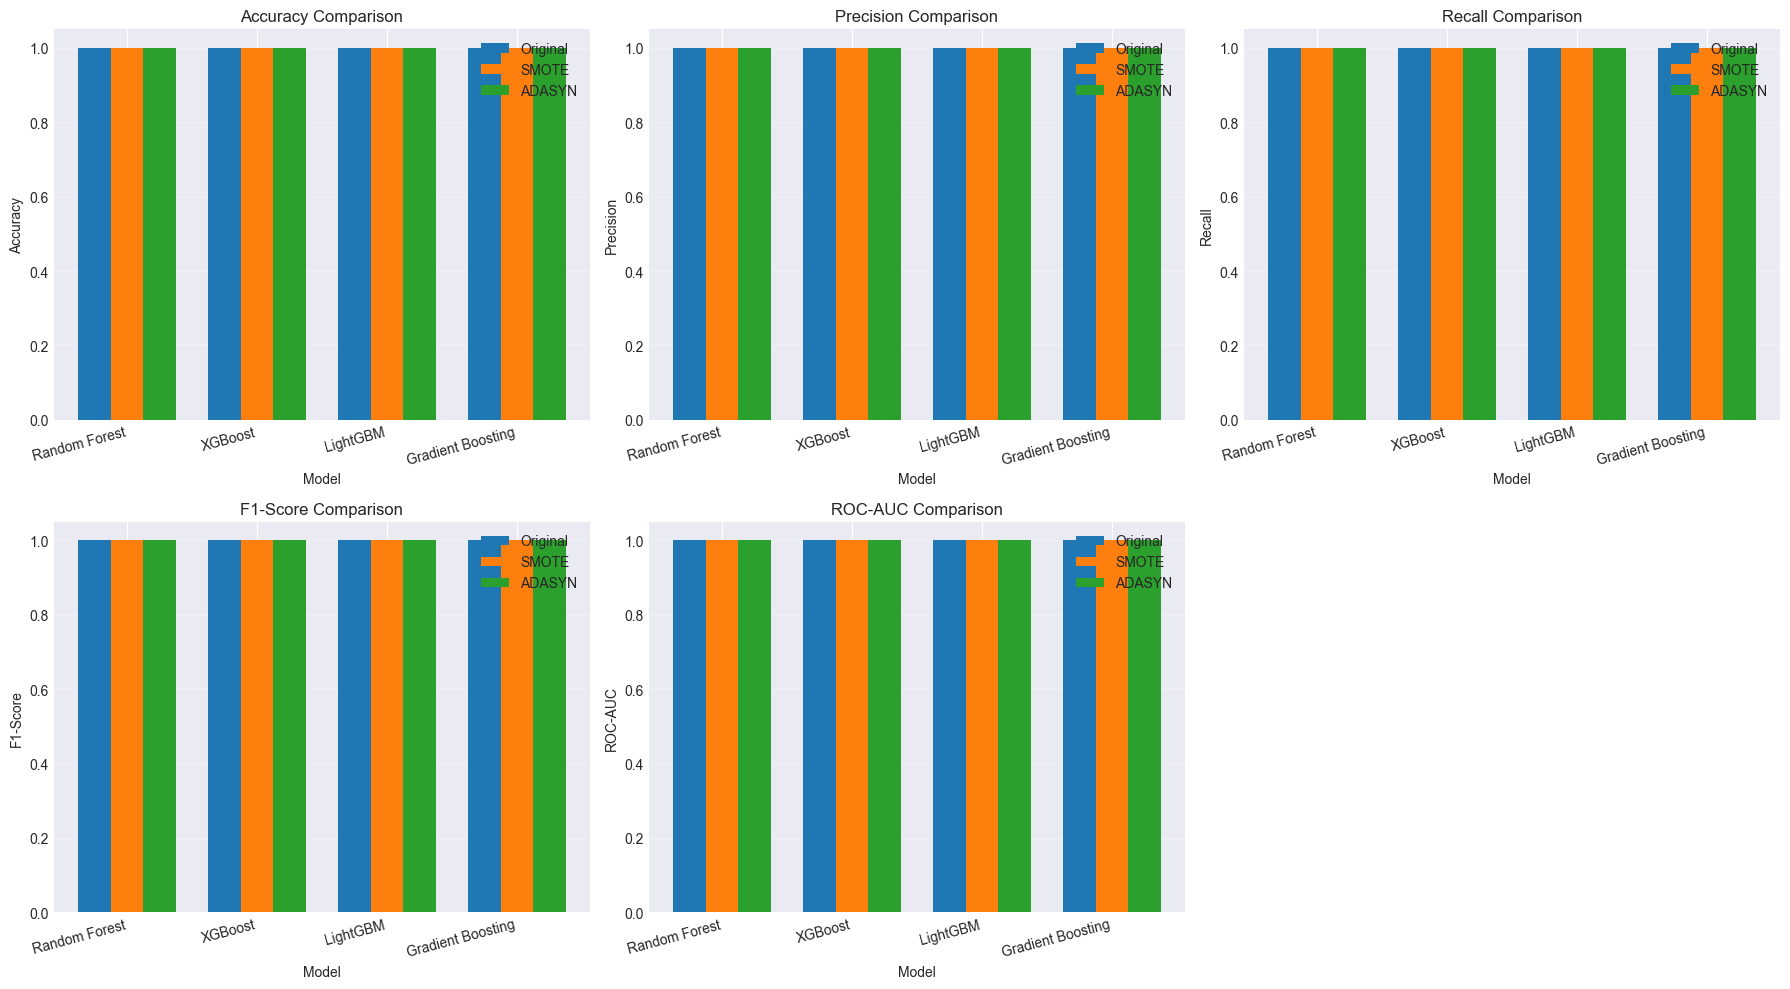


✓ Visualization complete!


In [630]:
# Visualize comparison
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']  # Blue, Orange, Green

for idx, metric in enumerate(metrics):
    row = idx // 3
    col = idx % 3
    
    # Prepare data for grouped bar chart
    dataset_names = ['Original', 'SMOTE', 'ADASYN']
    model_names = comparison_df['Model'].unique()
    
    x = np.arange(len(model_names))
    width = 0.25
    
    for i, dataset in enumerate(dataset_names):
        data = comparison_df[comparison_df['Dataset'] == dataset]
        values = [data[data['Model'] == model][metric].values[0] for model in model_names]
        axes[row, col].bar(x + i*width, values, width, label=dataset, color=colors[i])
    
    axes[row, col].set_xlabel('Model')
    axes[row, col].set_ylabel(metric)
    axes[row, col].set_title(f'{metric} Comparison')
    axes[row, col].set_xticks(x + width)
    axes[row, col].set_xticklabels(model_names, rotation=15, ha='right')
    axes[row, col].legend()
    axes[row, col].set_ylim([0, 1.05])
    axes[row, col].grid(axis='y', alpha=0.3)

# Remove empty subplot
axes[1, 2].axis('off')

plt.tight_layout()
plt.show()

print("\n✓ Visualization complete!")

### Visualization 2: Heatmap Comparison

CREATING HEATMAP COMPARISON


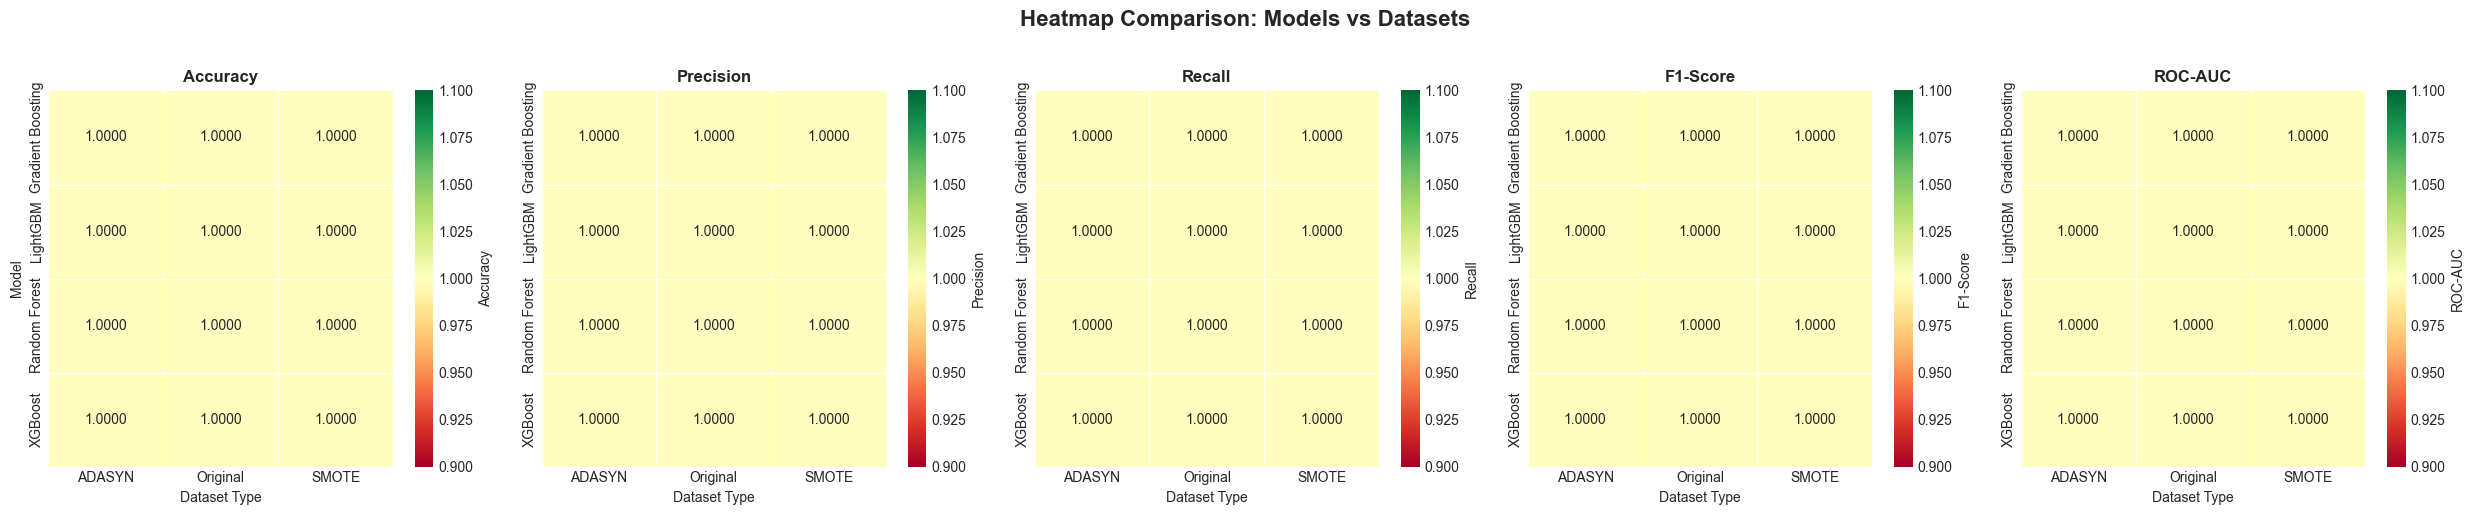


✓ Heatmap comparison complete!


In [631]:
# Heatmap comparison untuk setiap metrik
print("CREATING HEATMAP COMPARISON")
print("="*80)

metrics_list = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']

fig, axes = plt.subplots(1, 5, figsize=(25, 5))
fig.suptitle('Heatmap Comparison: Models vs Datasets', fontsize=16, fontweight='bold', y=1.02)

for idx, metric in enumerate(metrics_list):
    # Buat pivot table untuk heatmap
    pivot_data = comparison_df.pivot(index='Model', columns='Dataset', values=metric)
    
    # Buat heatmap
    sns.heatmap(pivot_data, annot=True, fmt='.4f', cmap='RdYlGn', 
                vmin=pivot_data.min().min(), vmax=pivot_data.max().max(),
                cbar_kws={'label': metric}, ax=axes[idx], linewidths=0.5)
    
    axes[idx].set_title(f'{metric}', fontsize=12, fontweight='bold')
    axes[idx].set_xlabel('Dataset Type', fontsize=10)
    axes[idx].set_ylabel('Model' if idx == 0 else '', fontsize=10)

plt.tight_layout()
plt.show()

print("\n✓ Heatmap comparison complete!")

CREATING CONFUSION MATRIX FOR BEST MODELS


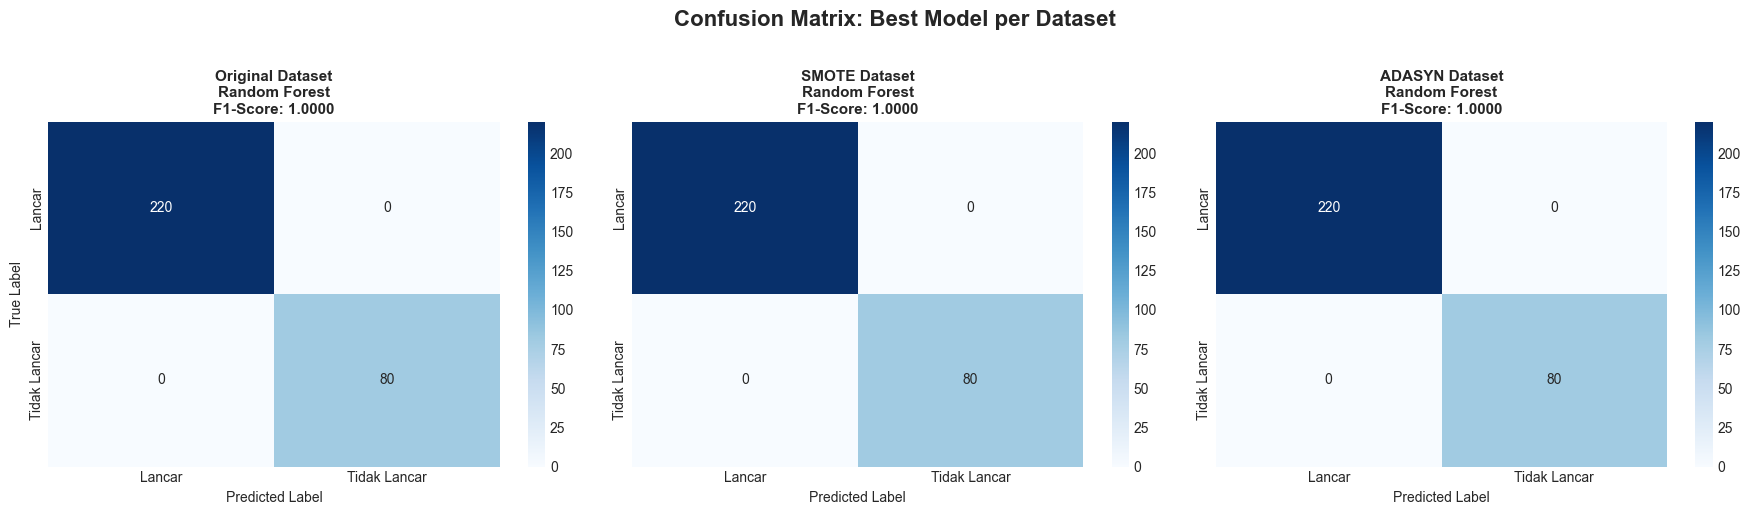


✓ Confusion matrix comparison complete!


In [632]:
# Confusion Matrix untuk best model dari setiap dataset
print("CREATING CONFUSION MATRIX FOR BEST MODELS")
print("="*80)

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('Confusion Matrix: Best Model per Dataset', fontsize=16, fontweight='bold', y=1.02)

datasets_dict = {
    'Original': (X_train_scaled, X_test_scaled, y_train, y_test),
    'SMOTE': (X_train_smote_scaled, X_test_smote_scaled, y_train_smote, y_test),
    'ADASYN': (X_train_adasyn_scaled, X_test_adasyn_scaled, y_train_adasyn, y_test)
}

for idx, (dataset_name, (X_tr, X_te, y_tr, y_te)) in enumerate(datasets_dict.items()):
    # Cari best model untuk dataset ini
    best_row = comparison_df[comparison_df['Dataset'] == dataset_name].sort_values('F1-Score', ascending=False).iloc[0]
    best_model_name = best_row['Model']
    
    # Train ulang best model
    if best_model_name == 'Random Forest':
        model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
    elif best_model_name == 'Gradient Boosting':
        model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)
    elif best_model_name == 'XGBoost':
        model = XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42, eval_metric='logloss', use_label_encoder=False)
    else:  # LightGBM
        model = LGBMClassifier(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42, verbose=-1)
    
    model.fit(X_tr, y_tr)
    y_pred = model.predict(X_te)
    
    # Buat confusion matrix
    cm = confusion_matrix(y_te, y_pred)
    
    # Plot
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx], 
                xticklabels=['Lancar', 'Tidak Lancar'],
                yticklabels=['Lancar', 'Tidak Lancar'])
    
    axes[idx].set_title(f'{dataset_name} Dataset\n{best_model_name}\nF1-Score: {best_row["F1-Score"]:.4f}', 
                        fontsize=11, fontweight='bold')
    axes[idx].set_xlabel('Predicted Label', fontsize=10)
    axes[idx].set_ylabel('True Label' if idx == 0 else '', fontsize=10)

plt.tight_layout()
plt.show()

print("\n✓ Confusion matrix comparison complete!")

### Visualization 4: ROC Curve Comparison

CREATING ROC CURVE COMPARISON


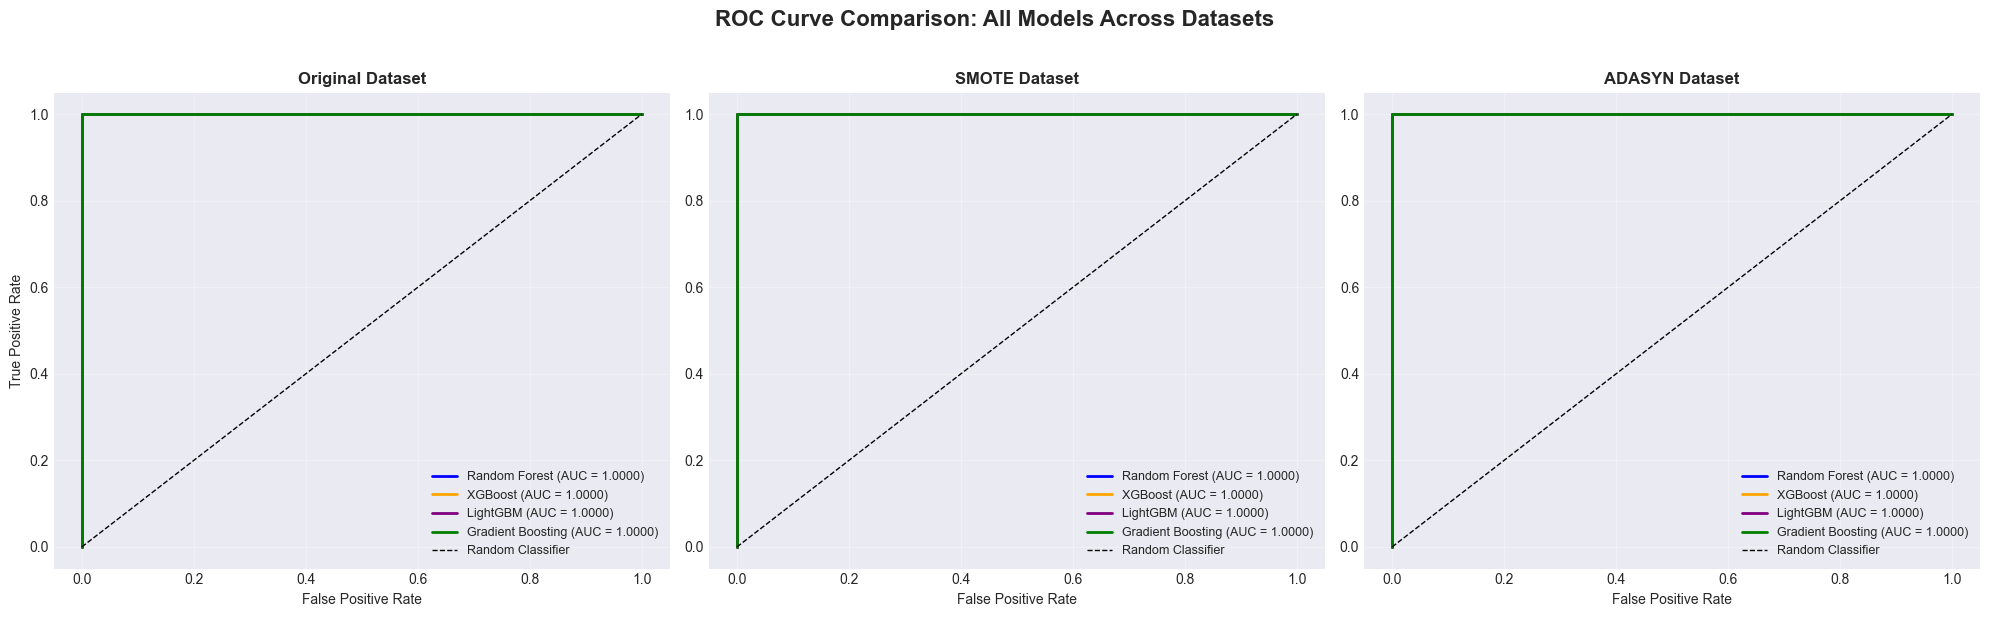


✓ ROC curve comparison complete!


In [633]:
# ROC Curve comparison untuk semua kombinasi
print("CREATING ROC CURVE COMPARISON")
print("="*80)

fig, axes = plt.subplots(1, 3, figsize=(20, 6))
fig.suptitle('ROC Curve Comparison: All Models Across Datasets', fontsize=16, fontweight='bold', y=1.02)

colors = {'Random Forest': 'blue', 'XGBoost': 'orange', 'LightGBM': 'purple', 'Gradient Boosting': 'green'}
datasets_dict = {
    'Original': (X_train_scaled, X_test_scaled, y_train, y_test),
    'SMOTE': (X_train_smote_scaled, X_test_smote_scaled, y_train_smote, y_test),
    'ADASYN': (X_train_adasyn_scaled, X_test_adasyn_scaled, y_train_adasyn, y_test)
}

for idx, (dataset_name, (X_tr, X_te, y_tr, y_te)) in enumerate(datasets_dict.items()):
    ax = axes[idx]
    
    for model_name in ['Random Forest', 'XGBoost', 'LightGBM', 'Gradient Boosting']:
        # Train model
        if model_name == 'Random Forest':
            model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
        elif model_name == 'XGBoost':
            model = XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42, eval_metric='logloss', use_label_encoder=False)
        elif model_name == 'LightGBM':
            model = LGBMClassifier(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42, verbose=-1)
        else:  # Gradient Boosting
            model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)
        
        model.fit(X_tr, y_tr)
        y_pred_proba = model.predict_proba(X_te)[:, 1]
        
        # Hitung ROC curve
        fpr, tpr, _ = roc_curve(y_te, y_pred_proba)
        roc_auc = auc(fpr, tpr)
        
        # Plot
        ax.plot(fpr, tpr, color=colors[model_name], lw=2, 
                label=f'{model_name} (AUC = {roc_auc:.4f})')
    
    # Plot diagonal
    ax.plot([0, 1], [0, 1], 'k--', lw=1, label='Random Classifier')
    
    ax.set_xlabel('False Positive Rate', fontsize=10)
    ax.set_ylabel('True Positive Rate' if idx == 0 else '', fontsize=10)
    ax.set_title(f'{dataset_name} Dataset', fontsize=12, fontweight='bold')
    ax.legend(loc='lower right', fontsize=9)
    ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✓ ROC curve comparison complete!")

### Visualization 5: Feature Importance Analysis

FEATURE IMPORTANCE ANALYSIS


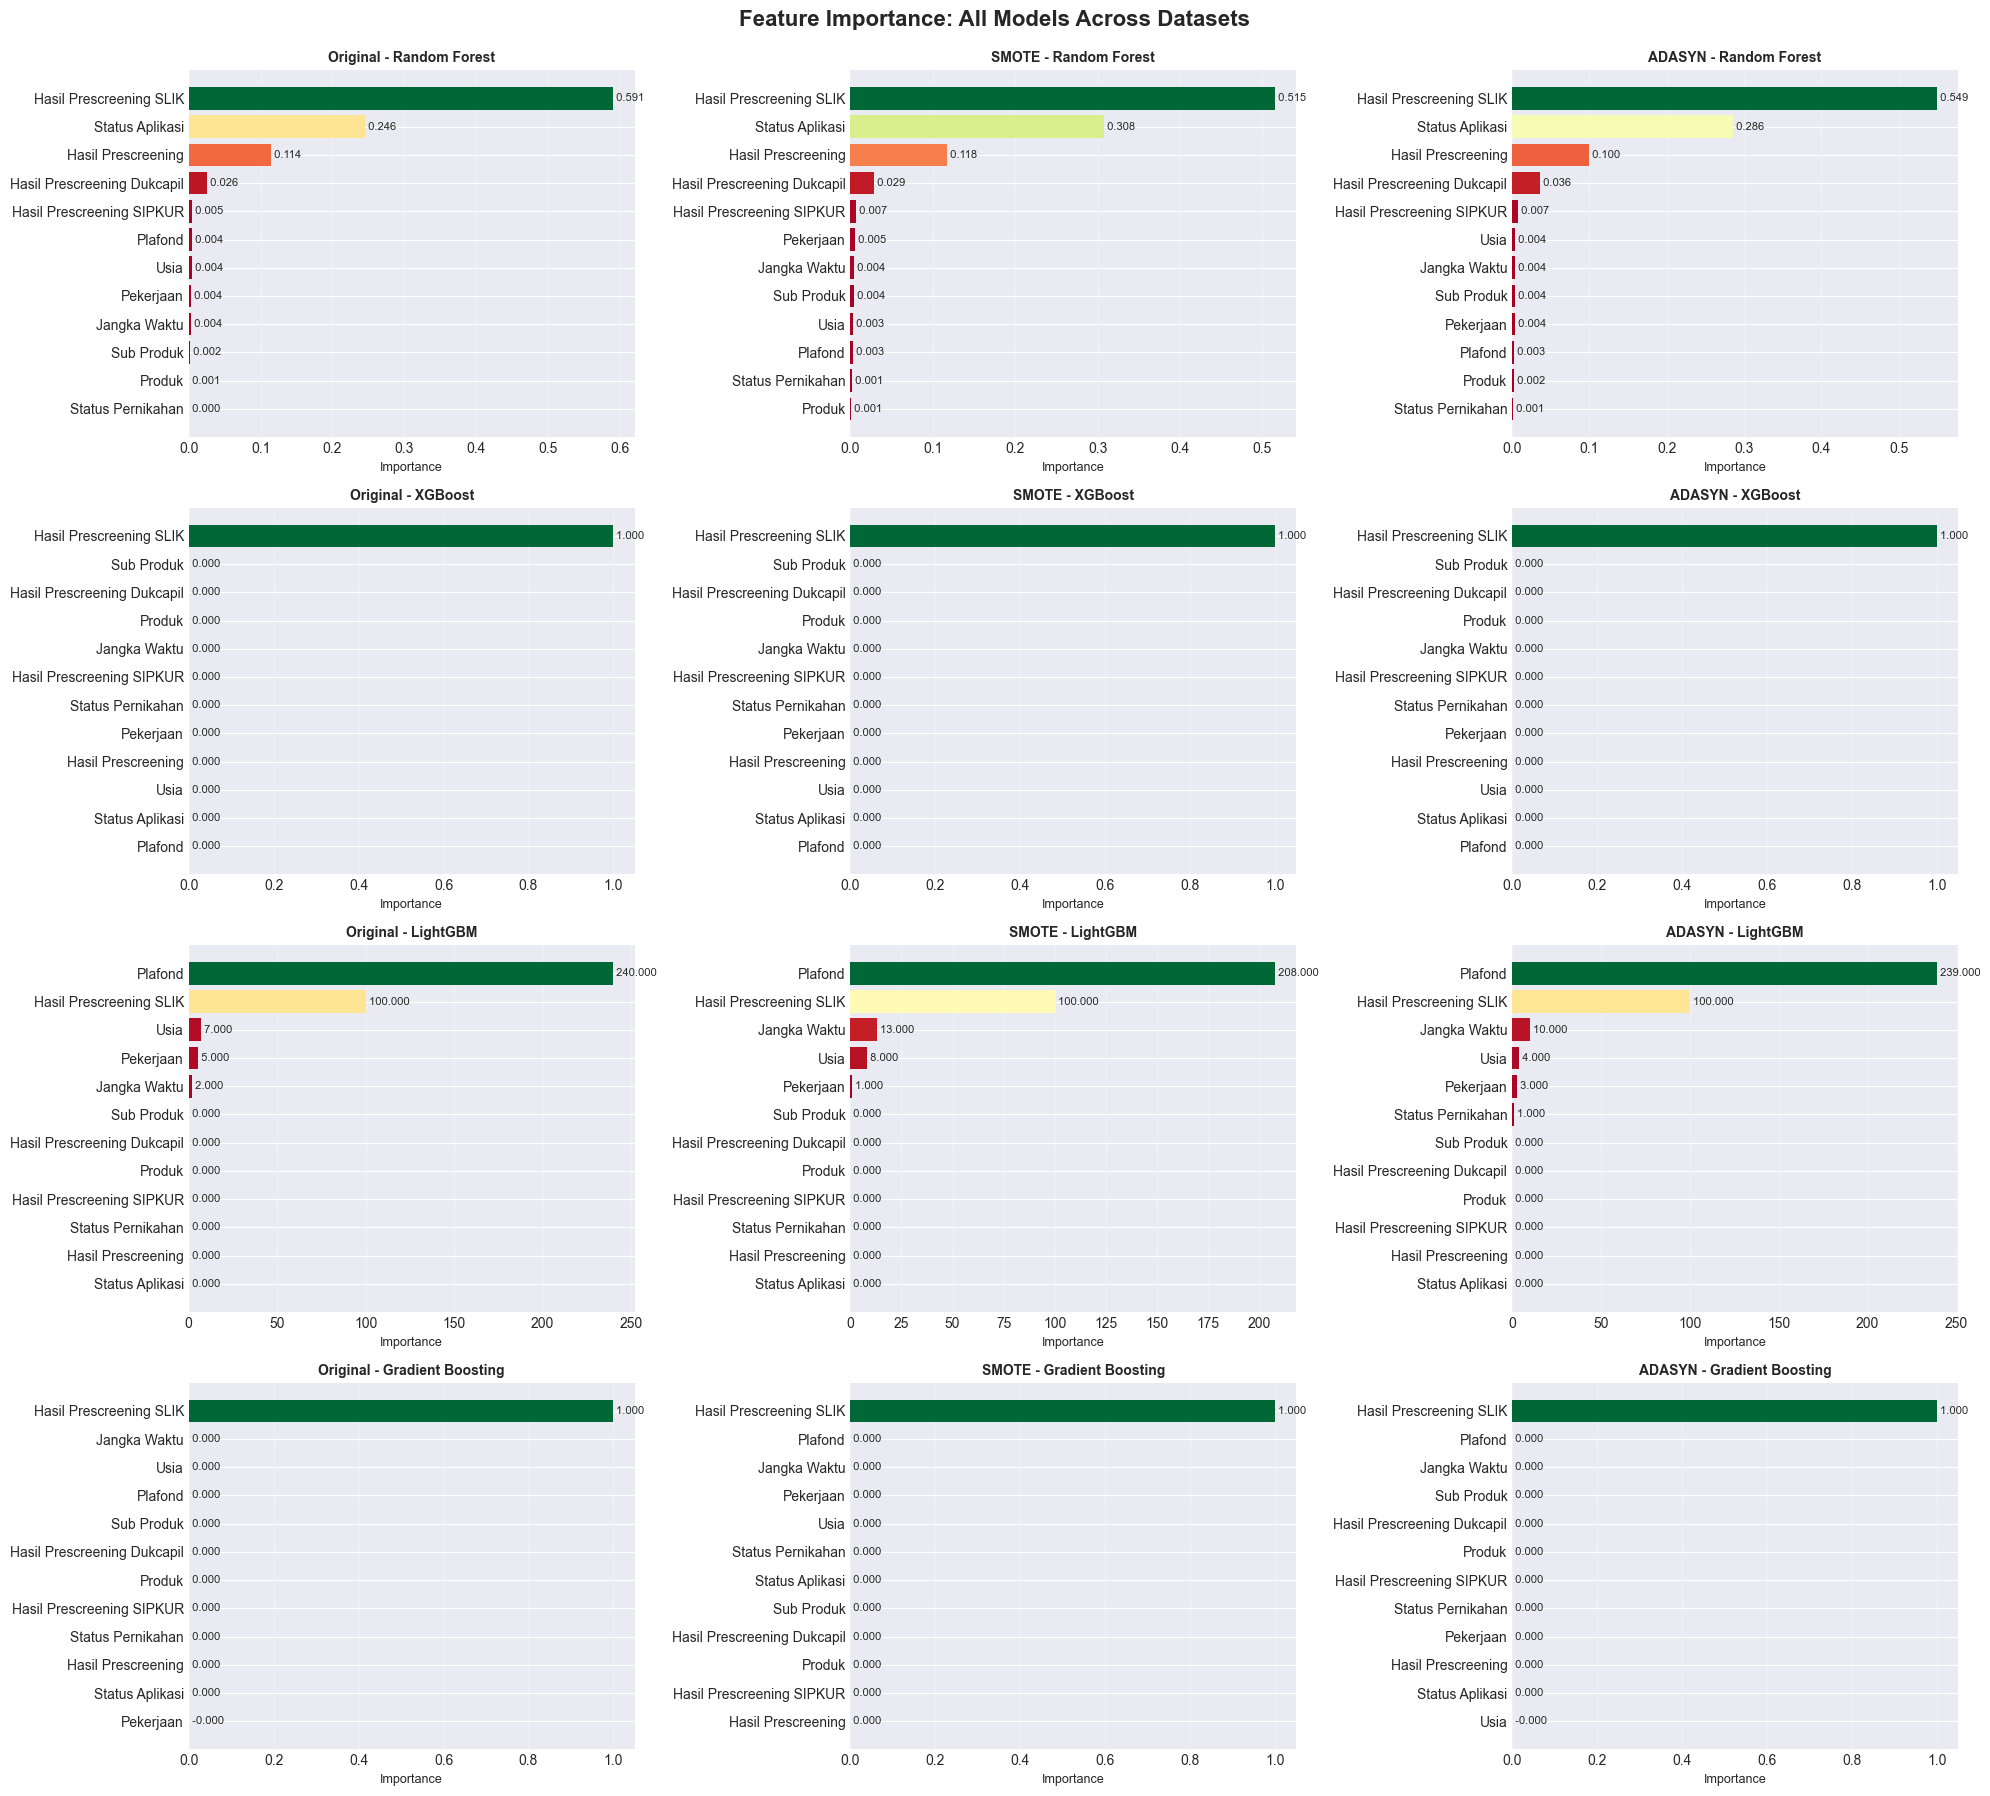


✓ Feature importance visualization complete!


In [634]:
# Feature Importance untuk semua model yang support feature_importances_
print("FEATURE IMPORTANCE ANALYSIS")
print("="*80)

fig, axes = plt.subplots(4, 3, figsize=(20, 18))
fig.suptitle('Feature Importance: All Models Across Datasets', fontsize=16, fontweight='bold', y=0.995)

datasets_dict = {
    'Original': (X_train_scaled, X_test_scaled, y_train, y_test),
    'SMOTE': (X_train_smote_scaled, X_test_smote_scaled, y_train_smote, y_test),
    'ADASYN': (X_train_adasyn_scaled, X_test_adasyn_scaled, y_train_adasyn, y_test)
}

model_configs = {
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1),
    'XGBoost': XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42, eval_metric='logloss', use_label_encoder=False),
    'LightGBM': LGBMClassifier(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42, verbose=-1),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)
}

for col_idx, (dataset_name, (X_tr, X_te, y_tr, y_te)) in enumerate(datasets_dict.items()):
    for row_idx, (model_name, model) in enumerate(model_configs.items()):
        ax = axes[row_idx, col_idx]
        
        # Train model
        from sklearn.base import clone
        trained_model = clone(model)
        trained_model.fit(X_tr, y_tr)
        
        # Get feature importance
        if hasattr(trained_model, 'feature_importances_'):
            importances = trained_model.feature_importances_
            
            # Create dataframe
            feature_imp_df = pd.DataFrame({
                'Feature': selected_features,
                'Importance': importances
            }).sort_values('Importance', ascending=True)
            
            # Plot horizontal bar
            colors_bar = plt.cm.RdYlGn(feature_imp_df['Importance'] / feature_imp_df['Importance'].max())
            ax.barh(feature_imp_df['Feature'], feature_imp_df['Importance'], color=colors_bar)
            ax.set_xlabel('Importance', fontsize=9)
            ax.set_title(f'{dataset_name} - {model_name}', fontsize=10, fontweight='bold')
            ax.grid(axis='x', alpha=0.3)
            
            # Add value labels
            for i, (idx, row) in enumerate(feature_imp_df.iterrows()):
                ax.text(row['Importance'], i, f' {row["Importance"]:.3f}', 
                       va='center', fontsize=8)

plt.tight_layout()
plt.show()

print("\n✓ Feature importance visualization complete!")

### Visualization 6: Top 5 Features Comparison


TOP 5 FEATURES PER MODEL-DATASET COMBINATION

Original Dataset:
--------------------------------------------------------------------------------

  Random Forest:
    1. Hasil Prescreening SLIK        (0.5912)
    2. Status Aplikasi                (0.2458)
    3. Hasil Prescreening             (0.1139)
    4. Hasil Prescreening Dukcapil    (0.0258)
    5. Hasil Prescreening SIPKUR      (0.0047)

  XGBoost:
    1. Hasil Prescreening SLIK        (1.0000)
    2. Plafond                        (0.0000)
    3. Status Aplikasi                (0.0000)
    4. Usia                           (0.0000)
    5. Hasil Prescreening             (0.0000)

  LightGBM:
    1. Plafond                        (240.0000)
    2. Hasil Prescreening SLIK        (100.0000)
    3. Usia                           (7.0000)
    4. Pekerjaan                      (5.0000)
    5. Jangka Waktu                   (2.0000)

  Random Forest:
    1. Hasil Prescreening SLIK        (0.5912)
    2. Status Aplikasi               

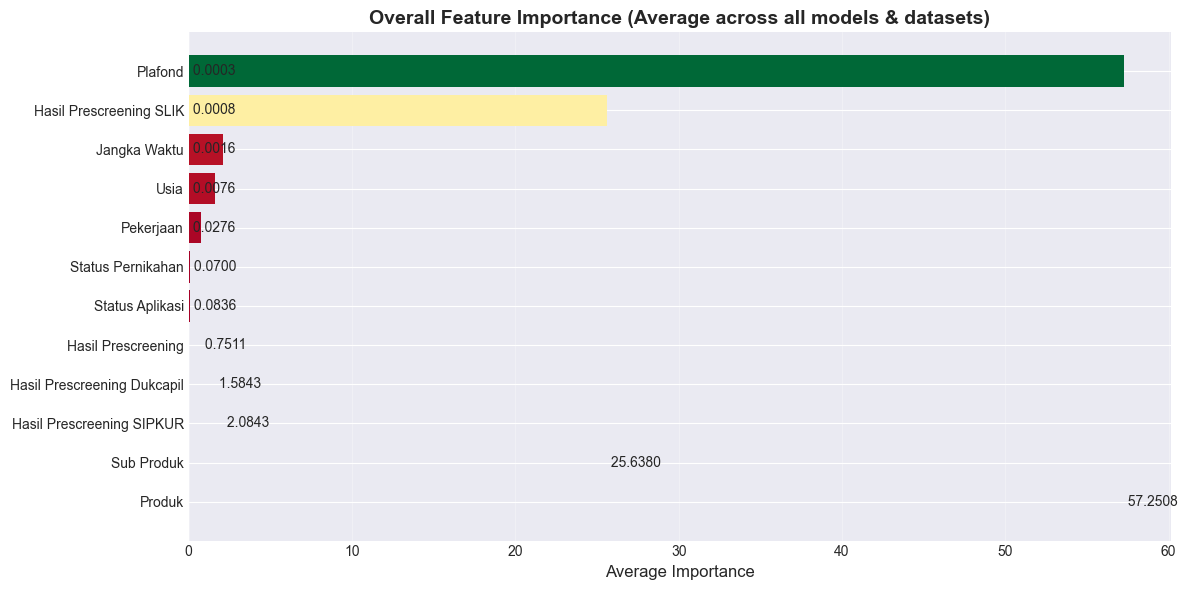


✓ Overall feature importance analysis complete!


In [635]:
# Summary: Top 5 features untuk setiap kombinasi
print("\nTOP 5 FEATURES PER MODEL-DATASET COMBINATION")
print("="*80)

for dataset_name, (X_tr, X_te, y_tr, y_te) in datasets_dict.items():
    print(f"\n{dataset_name} Dataset:")
    print("-"*80)
    
    for model_name, model in model_configs.items():
        from sklearn.base import clone
        trained_model = clone(model)
        trained_model.fit(X_tr, y_tr)
        
        if hasattr(trained_model, 'feature_importances_'):
            importances = trained_model.feature_importances_
            
            feature_imp_df = pd.DataFrame({
                'Feature': selected_features,
                'Importance': importances
            }).sort_values('Importance', ascending=False).head(5)
            
            print(f"\n  {model_name}:")
            for idx, (i, row) in enumerate(feature_imp_df.iterrows(), 1):
                print(f"    {idx}. {row['Feature']:30s} ({row['Importance']:.4f})")

# Overall feature importance (average across all models and datasets)
print("\n\n" + "="*80)
print("OVERALL FEATURE IMPORTANCE (Average across all combinations)")
print("="*80)

all_importances = []

for dataset_name, (X_tr, X_te, y_tr, y_te) in datasets_dict.items():
    for model_name, model in model_configs.items():
        from sklearn.base import clone
        trained_model = clone(model)
        trained_model.fit(X_tr, y_tr)
        
        if hasattr(trained_model, 'feature_importances_'):
            all_importances.append(trained_model.feature_importances_)

# Calculate average importance
avg_importances = np.mean(all_importances, axis=0)
overall_imp_df = pd.DataFrame({
    'Feature': selected_features,
    'Average_Importance': avg_importances
}).sort_values('Average_Importance', ascending=False)

print("\nRanking:")
for idx, (i, row) in enumerate(overall_imp_df.iterrows(), 1):
    print(f"{idx:2d}. {row['Feature']:30s} {row['Average_Importance']:.4f}")

# Visualize overall importance
plt.figure(figsize=(12, 6))
colors_bar = plt.cm.RdYlGn(overall_imp_df['Average_Importance'] / overall_imp_df['Average_Importance'].max())
plt.barh(overall_imp_df['Feature'], overall_imp_df['Average_Importance'], color=colors_bar)
plt.xlabel('Average Importance', fontsize=12)
plt.title('Overall Feature Importance (Average across all models & datasets)', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)

# Add value labels
for i, (idx, row) in enumerate(overall_imp_df[::-1].iterrows()):
    plt.text(row['Average_Importance'], i, f' {row["Average_Importance"]:.4f}', 
            va='center', fontsize=10)

plt.tight_layout()
plt.show()

print("\n✓ Overall feature importance analysis complete!")

## 21. Final Recommendation & Best Model Selection

In [636]:
# Pilih best model berdasarkan F1-Score (karena data imbalanced)
print("BEST MODEL SELECTION")
print("="*80)

# Cari best model overall
best_overall = comparison_df.sort_values('F1-Score', ascending=False).iloc[0]

print(f"\n🏆 BEST MODEL OVERALL:")
print(f"   Model: {best_overall['Model']}")
print(f"   Dataset: {best_overall['Dataset']}")
print(f"   Accuracy: {best_overall['Accuracy']:.4f}")
print(f"   Precision: {best_overall['Precision']:.4f}")
print(f"   Recall: {best_overall['Recall']:.4f}")
print(f"   F1-Score: {best_overall['F1-Score']:.4f}")
print(f"   ROC-AUC: {best_overall['ROC-AUC']:.4f}")

# Analisis per dataset
print("\n" + "="*80)
print("BEST MODEL PER DATASET:")
print("="*80)

for dataset_name in ['Original', 'SMOTE', 'ADASYN']:
    best_per_dataset = comparison_df[comparison_df['Dataset'] == dataset_name].sort_values('F1-Score', ascending=False).iloc[0]
    print(f"\n{dataset_name} Dataset:")
    print(f"   Best Model: {best_per_dataset['Model']}")
    print(f"   F1-Score: {best_per_dataset['F1-Score']:.4f}")
    print(f"   ROC-AUC: {best_per_dataset['ROC-AUC']:.4f}")

# Rekomendasi
print("\n" + "="*80)
print("RECOMMENDATION:")
print("="*80)

avg_by_dataset = comparison_df.groupby('Dataset')['F1-Score'].mean().sort_values(ascending=False)
print("\nAverage F1-Score by Dataset:")
for dataset, score in avg_by_dataset.items():
    print(f"   {dataset}: {score:.4f}")

print("\n💡 INSIGHTS:")
if avg_by_dataset.index[0] == 'Original':
    print("   • Original dataset performs best - class imbalance is not severe")
    print("   • SMOTE/ADASYN may introduce noise or overfitting")
elif avg_by_dataset.index[0] == 'SMOTE':
    print("   • SMOTE improves performance - synthetic samples help model learning")
    print("   • Class imbalance was limiting model performance")
else:  # ADASYN
    print("   • ADASYN performs best - adaptive sampling helps with difficult examples")
    print("   • Minority class has complex patterns that benefit from focused synthesis")

print("\n✓ Analysis complete!")
print("="*80)

BEST MODEL SELECTION

🏆 BEST MODEL OVERALL:
   Model: Random Forest
   Dataset: Original
   Accuracy: 1.0000
   Precision: 1.0000
   Recall: 1.0000
   F1-Score: 1.0000
   ROC-AUC: 1.0000

BEST MODEL PER DATASET:

Original Dataset:
   Best Model: Random Forest
   F1-Score: 1.0000
   ROC-AUC: 1.0000

SMOTE Dataset:
   Best Model: Random Forest
   F1-Score: 1.0000
   ROC-AUC: 1.0000

ADASYN Dataset:
   Best Model: Random Forest
   F1-Score: 1.0000
   ROC-AUC: 1.0000

RECOMMENDATION:

Average F1-Score by Dataset:
   ADASYN: 1.0000
   Original: 1.0000
   SMOTE: 1.0000

💡 INSIGHTS:
   • ADASYN performs best - adaptive sampling helps with difficult examples
   • Minority class has complex patterns that benefit from focused synthesis

✓ Analysis complete!


## 16. Save Best Model

In [637]:
# Save best model berdasarkan F1-Score
print("SAVING BEST MODEL")
print("="*80)

best_overall = comparison_df.sort_values('F1-Score', ascending=False).iloc[0]

# Tentukan dataset yang digunakan
if best_overall['Dataset'] == 'Original':
    X_tr, X_te, y_tr, y_te = X_train_scaled, X_test_scaled, y_train, y_test
elif best_overall['Dataset'] == 'SMOTE':
    X_tr, X_te, y_tr, y_te = X_train_smote_scaled, X_test_smote_scaled, y_train_smote, y_test
else:  # ADASYN
    X_tr, X_te, y_tr, y_te = X_train_adasyn_scaled, X_test_adasyn_scaled, y_train_adasyn, y_test

# Train best model
if best_overall['Model'] == 'Random Forest':
    best_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
elif best_overall['Model'] == 'Gradient Boosting':
    best_model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)
elif best_overall['Model'] == 'XGBoost':
    best_model = XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42, eval_metric='logloss', use_label_encoder=False)
else:  # LightGBM
    best_model = LGBMClassifier(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42, verbose=-1)

best_model.fit(X_tr, y_tr)
print(f"✓ Best model ({best_overall['Model']}) trained on {best_overall['Dataset']} dataset")

# Timestamp
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')

# Save model
model_filename = f'models/best_model_{best_overall["Model"].lower().replace(" ", "_")}_{timestamp}.joblib'
joblib.dump(best_model, model_filename)
print(f"✓ Model saved: {model_filename}")

# Save encoders
encoders_filename = f'models/label_encoders_{timestamp}.joblib'
joblib.dump(label_encoders, encoders_filename)
print(f"✓ Encoders saved: {encoders_filename}")

# Save target encoder
target_encoder_filename = f'models/target_encoder_{timestamp}.joblib'
joblib.dump(target_encoder, target_encoder_filename)
print(f"✓ Target encoder saved: {target_encoder_filename}")

# Save scaler (sesuaikan dengan dataset yang digunakan)
scaler_filename = f'models/scaler_{timestamp}.joblib'
if best_overall['Dataset'] == 'Original':
    joblib.dump(scaler_original, scaler_filename)
elif best_overall['Dataset'] == 'SMOTE':
    joblib.dump(scaler_smote, scaler_filename)
else:
    joblib.dump(scaler_adasyn, scaler_filename)
print(f"✓ Scaler saved: {scaler_filename}")

# Save metadata
metadata = {
    'model_name': best_overall['Model'],
    'dataset_type': best_overall['Dataset'],
    'timestamp': timestamp,
    'accuracy': float(best_overall['Accuracy']),
    'precision': float(best_overall['Precision']),
    'recall': float(best_overall['Recall']),
    'f1_score': float(best_overall['F1-Score']),
    'roc_auc': float(best_overall['ROC-AUC']),
    'features': feature_columns,
    'target_classes': target_encoder.classes_.tolist(),
    'model_file': model_filename,
    'encoders_file': encoders_filename,
    'target_encoder_file': target_encoder_filename,
    'scaler_file': scaler_filename,
    'imbalanced_handling': best_overall['Dataset']
}

metadata_filename = f'models/model_metadata_{timestamp}.json'
with open(metadata_filename, 'w') as f:
    json.dump(metadata, f, indent=4)
print(f"✓ Metadata saved: {metadata_filename}")

print(f"\n{'='*80}")
print(f"✅ BEST MODEL SAVED SUCCESSFULLY")
print(f"{'='*80}")
print(f"Model: {best_overall['Model']}")
print(f"Dataset: {best_overall['Dataset']}")
print(f"F1-Score: {best_overall['F1-Score']:.4f}")
print(f"ROC-AUC: {best_overall['ROC-AUC']:.4f}")

SAVING BEST MODEL


✓ Best model (Random Forest) trained on Original dataset
✓ Model saved: models/best_model_random_forest_20251215_154134.joblib
✓ Encoders saved: models/label_encoders_20251215_154134.joblib
✓ Target encoder saved: models/target_encoder_20251215_154134.joblib
✓ Scaler saved: models/scaler_20251215_154134.joblib
✓ Metadata saved: models/model_metadata_20251215_154134.json

✅ BEST MODEL SAVED SUCCESSFULLY
Model: Random Forest
Dataset: Original
F1-Score: 1.0000
ROC-AUC: 1.0000
